In [1]:
import os
os.environ["http_proxy"] = "http://proxy.cmu.edu:3128"
os.environ["https_proxy"] = "https://proxy.cmu.edu:3128"
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [2]:
import librosa
import numpy as np
import sklearn
import sklearn.metrics
import gc
import zipfile
import pandas as pd
import random
from tqdm.autonotebook import tqdm
import os
import datetime
import torch.nn as nn
import torch
from adamp import AdamP
from torchsummaryX import summary
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print("Device: ", device)

ModuleNotFoundError: No module named 'numpy.random._bit_generator'

In [ ]:
root = "./data/wav_resampled16kHz"

In [3]:
config = {
    'epochs': 5,
    'batch_size' : 512,
    'context' : 10,
    'learning_rate' : 0.001,
    'architecture' : 'medium-cutoff'
    # Add more as you need them - e.g dropout values, weight decay, scheduler parameters
}

In [16]:
# Dataset class to load train and validation data

from calendar import day_abbr
from sklearn.preprocessing import normalize


class AudioDataset(torch.utils.data.Dataset):

    def __init__(self, data_path, context, offset=0, partition= "train", limit=-1, shuffle=True, Normalization=True, mfcc_list=["mfcc", "mfcc_320", "mfcc_480"]): # Feel free to add more arguments

        self.context = context
        self.offset = context
        self.data_path = data_path
        self.normalization = Normalization
        self.mfcc_list = mfcc_list
        
        self.mfcc_list = []
        self.transcripts = []
        for index, mfcc_file in enumerate(mfcc_list):
            self.mfcc_dir = data_path + '/' + partition + "/" + mfcc_file + "/"
            self.transcript_dir = data_path + '/' + partition + "/labels/"

            mfcc_names = sorted(os.listdir(self.mfcc_dir))
            transcript_names = sorted(os.listdir(self.transcript_dir))
            assert len(mfcc_names) == len(transcript_names)

            self.mfccs = []

            for i in range(0, len(mfcc_names)):
    
                mfcc = np.load(self.mfcc_dir + mfcc_names[i])
                self.mfccs.append(mfcc)
            #   Optionally do Cepstral Normalization of mfcc
            #   Load the corresponding transcript
                if index == 0:
                    transcript = np.load(self.transcript_dir + transcript_names[i])
                    self.transcripts.append(transcript)

            # if partition == "train":
            #     if shuffle == True:
            #         Pairs = list(zip(self.mfccs, self.transcripts))
            #         random.shuffle(Pairs)
            #         self.mfccs, self.transcripts = zip(*Pairs)

            # Each mfcc is of shape T1 x 20, T2 x 20, ...
            # Each transcript is of shape (T1+2) x 20, (T2+2) x 20

            # TODO: Concatenate all mfccs in self.X such that the final shape is T x 20 (Where T = T1 + T2 + ...) 
            self.mfccs = np.concatenate(self.mfccs, axis=0)
            self.length = len(self.mfccs)
            # TODO: Concatenate all transcripts in self.Y such that the final shape is (T,) meaning, each time step has one phoneme output
            if index == 0:
                self.transcripts = np.concatenate(self.transcripts, axis=0)
            # Hint: Use numpy to concatenate
            # Take some time to think about what we have done. self.mfcc is an array of the format (Frames x Features). Our goal is to recognize phonemes of each frame
            # From hw0, you will be knowing what context is. We can introduce context by padding zeros on top and bottom of self.mfcc
            if context != 0:
                zero_paddings = np.zeros((context, 20))
                up_paded = np.vstack((zero_paddings, self.mfccs))
                down_paded = np.vstack((up_paded, zero_paddings))
                self.mfccs = down_paded
                
            self.mfcc_list.append(self.mfccs)
        self.mfccs = np.stack(self.mfcc_list)


    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        
        start_index = ind + self.offset - self.context
        
        ## Calculate ending timestep using offset and context (1 line)
        end_index = ind + self.offset + self.context + 1

        frames = self.mfccs[:, start_index:end_index, :]
        
        # TODO: Based on context and offset, return a frame at given index with context frames to the left, and right.
        # After slicing, you get an array of shape 2*context+1 x 15. But our MLP needs 1d data and not 2d.
        height = frames.shape[0]
        width = frames.shape[1]
        if self.normalization == True:
          frames = frames - frames.mean(axis=0, keepdims=True)
          # frames_variance = np.var(frames, axis=0)
          # frames = np.divide(frames, np.tile(frames_variance, (height, 1)))
        frames = torch.FloatTensor(frames) # Convert to tensors
        onset = torch.tensor(self.transcripts[ind])       
        
        return frames, onset

In [17]:
class AudioTestDataset(torch.utils.data.Dataset):
    # TODO: Create a test dataset class similar to the previous class but you dont have transcripts for this
    # Imp: Read the mfccs in sorted order, do NOT shuffle the data here or in your dataloader.
    def __init__(self, data_path, context, offset=0, limit=-1, Normalization=True, mfcc_list=["mfcc", "mfcc_320", "mfcc_480"]): # Feel free to add more arguments

        self.context = context
        self.offset = context
        self.data_path = data_path
        self.mfcc_dir = data_path + '/' + "test" + "/mfcc/"
        self.normalization = Normalization
        mfcc_names = sorted(os.listdir(self.mfcc_dir))
        self.mfcc_list = mfcc_list
        
        self.mfcc_list = []
        for mfcc_file in mfcc_list:
            
            self.mfccs= []
            for i in range(0, len(mfcc_names)):
            #   Load a single mfcc
                mfcc = np.load(self.mfcc_dir + mfcc_names[i])
                self.mfccs.append(mfcc)

            # NOTE:
            # Each mfcc is of shape T1 x 20, T2 x 20, ...
            # Each transcript is of shape (T1+2) x 20, (T2+2) x 20 before removing [SOS] and [EOS]

            self.mfccs = np.concatenate(self.mfccs, axis=0)
            self.length = len(self.mfccs)

            # Take some time to think about what we have done. self.mfcc is an array of the format (Frames x Features). Our goal is to recognize phonemes of each frame
            # From hw0, you will be knowing what context is. We can introduce context by padding zeros on top and bottom of self.mfcc
            if context != 0:
                zero_paddings = np.zeros((context, 20))
                up_paded = np.vstack((zero_paddings, self.mfccs))
                down_paded = np.vstack((up_paded, zero_paddings))
                self.mfccs = down_paded
            
            self.mfcc_list.append(self.mfccs)
        self.mfccs = np.stack(self.mfcc_list)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):

        start_index = ind + self.offset - self.context
        ## Calculate ending timestep using offset and context (1 line)
        end_index = ind + self.offset + self.context + 1
        frames = self.mfccs[:, start_index:end_index, :]
        height = frames.shape[0]
        width = frames.shape[1]
        if self.normalization == True:
          frames = frames - frames.mean(axis=0, keepdims=True)

        frames = torch.FloatTensor(frames) # Convert to tensors 

        return frames

In [19]:
data_path = root
train_data = AudioDataset(data_path, context = config['context'], offset=0, partition= "train", limit=-1)
val_data = AudioDataset(data_path, context = config['context'], offset=0, partition= "dev", limit=-1, shuffle=False) 
test_data = AudioDataset(data_path, context = config['context'], offset=0, partition= "test", limit=-1, shuffle=False) 

In [21]:
train_mfcc = train_data.mfccs
validation_mfcc = val_data.mfccs
test_mfcc = test_data.mfccs

train_label = train_data.transcripts
validation_label = val_data.transcripts
test_label = test_data.transcripts

In [36]:
train_unique, train_counts = np.unique(train_label, return_counts=True)
validation_unique, validation_counts = np.unique(validation_label, return_counts=True)
testing_unique, testing_counts = np.unique(test_label, return_counts=True)

In [39]:
testing_counts

array([15477,  2500])

In [40]:
test_label.shape

(17977, 1)

In [7]:
df_train_loss = pd.read_csv("./baseline_data/baseline_train_loss.csv")
df_val_loss = pd.read_csv("./baseline_data/baseline_val_loss.csv")


In [11]:
epoch = np.arange(start=0, stop=100, step=1)
train_loss = df_train_loss.iloc[:, 2]
val_loss = df_val_loss.iloc[:, 2]

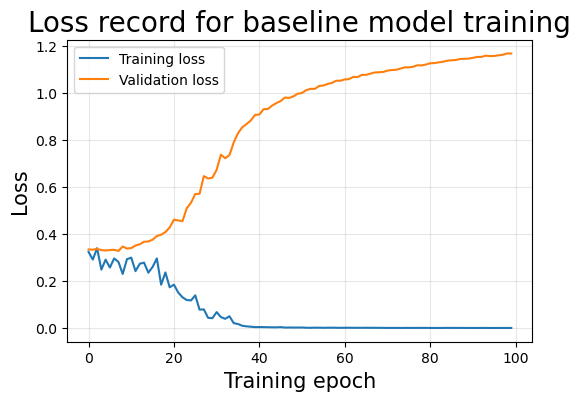

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.plot(epoch, train_loss, label="Training loss")
ax.plot(epoch, val_loss, label="Validation loss")
ax.set_xlabel("Training epoch", size=15)
ax.set_ylabel("Loss", size=15)
ax.set_title("Loss record for baseline model training", size=20)
ax.grid(alpha=0.3)
ax.legend()
fig.savefig("./baseline_data/img/baseline_no_dropout.pdf")

In [5]:
model = torch.load("model_checkpoint_base.pth")

In [6]:
model

{'epoch': 2,
 'model_state_dict': OrderedDict([('conv1.weight',
               tensor([[[[ 0.0093,  0.0482, -0.1308],
                         [ 0.0532, -0.0196, -0.0960],
                         [ 0.0922, -0.0399, -0.0430],
                         [ 0.2359, -0.1763,  0.0236],
                         [ 0.0713, -0.0212, -0.1483]],
               
                        [[ 0.0629,  0.1624,  0.0663],
                         [ 0.0540, -0.0599,  0.1582],
                         [ 0.1231,  0.2121,  0.1203],
                         [ 0.0827, -0.0281,  0.1044],
                         [-0.1002, -0.0109,  0.2285]],
               
                        [[ 0.0641,  0.1036, -0.0669],
                         [ 0.0103, -0.1116, -0.1299],
                         [-0.1113,  0.1341, -0.0502],
                         [ 0.0549,  0.0295,  0.0951],
                         [-0.1803,  0.1566, -0.0904]]],
               
               
                       [[[ 0.1696, -0.0047, -0.0648],
    